In [1]:
# Install the necessary packages
!pip install datasets
!pip install tokenizers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 2.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.0 MB/s eta 0:00:

In [2]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from transformers import AutoTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [3]:
# constants
VOCAB_SIZE = 1000
TOKENIZER_TO_MODEL = {"bpe":"gpt2","wordpiece":"google/electra-base-discriminator","unigram":"roberta-base"}

In [5]:
# Load the SST dataset
dataset_train = load_dataset('sst', split='train')
dataset_dev = load_dataset('sst', split='validation')
dataset_test = load_dataset('sst', split='test')

# Print some examples from the dataset
print(dataset_train[0]["sentence"])
print(dataset_train[0]["label"])

The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .
0.6944400072097778


In [6]:
# Convert the dataset to a pandas DataFrame
df_train = pd.DataFrame(dataset_train)[['sentence', 'label']]
df_dev = pd.DataFrame(dataset_dev)[['sentence', 'label']]
df_test = pd.DataFrame(dataset_test)[['sentence', 'label']]

In [7]:
# Round the label column to 0 or 1
for df in [df_train, df_dev, df_test]:
  df['label'] = df['label'].apply(lambda x: round(x))

df_train.head()

,sentence,label
0,The Rock is destined to be the 21st Century 's...,1
1,The gorgeously elaborate continuation of `` Th...,1
2,Singer\/composer Bryan Adams contributes a sle...,1
3,You 'd think by now America would have had eno...,0
4,Yet the act is still charming here .,1


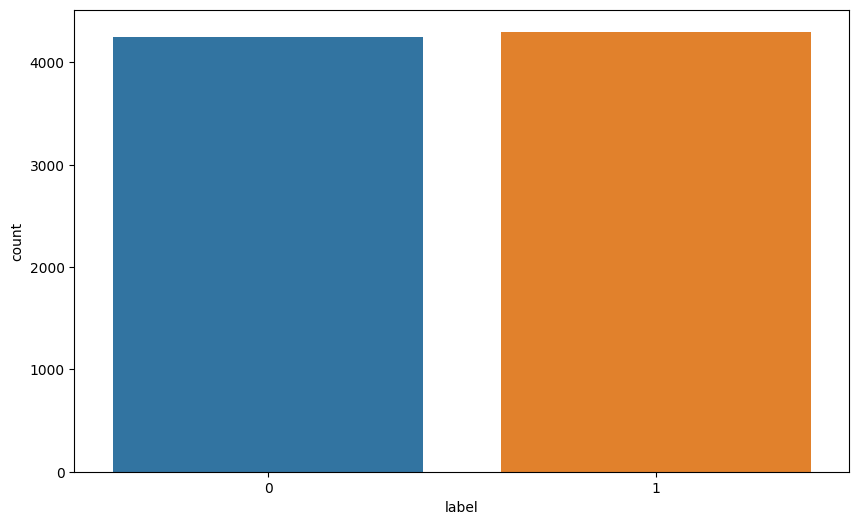

In [8]:
# Visualizing the distribution of the target variable
plt.figure(figsize=(10,6))
sns.countplot(x='label', data=df_train)

plt.show()

In [9]:
# create the list of tokenizers
tokenizers = []
for model_name in TOKENIZER_TO_MODEL.values():
  tokenizers.append(AutoTokenizer.from_pretrained(model_name))

# Tokenize the text in the DataFrame
for df in [df_train, df_dev, df_test]:
  for tokenizer,tokenizer_name in zip(tokenizers,TOKENIZER_TO_MODEL.keys()):
    df[f"tokenized_by_{tokenizer_name}"] = df['sentence'].apply(lambda x: ' '.join(tokenizer.tokenize(x)))

In [10]:
df_train.head()

,sentence,label,tokenized_by_bpe,tokenized_by_wordpiece,tokenized_by_unigram
0,The Rock is destined to be the 21st Century 's...,1,The ĠRock Ġis Ġdestined Ġto Ġbe Ġthe Ġ21 st ĠC...,the rock is destined to be the 21st century ' ...,The ĠRock Ġis Ġdestined Ġto Ġbe Ġthe Ġ21 st ĠC...
1,The gorgeously elaborate continuation of `` Th...,1,The Ġgorge ously Ġelaborate Ġcontinuation Ġof ...,the gorgeous ##ly elaborate continuation of ` ...,The Ġgorge ously Ġelaborate Ġcontinuation Ġof ...
2,Singer\/composer Bryan Adams contributes a sle...,1,S inger \/ com pos er ĠBryan ĠAdams Ġcontribut...,singer \ / composer bryan adams contributes a ...,S inger \/ com pos er ĠBryan ĠAdams Ġcontribut...
3,You 'd think by now America would have had eno...,0,You Ġ' d Ġthink Ġby Ġnow ĠAmerica Ġwould Ġhave...,you ' d think by now america would have had en...,You Ġ' d Ġthink Ġby Ġnow ĠAmerica Ġwould Ġhave...
4,Yet the act is still charming here .,1,Yet Ġthe Ġact Ġis Ġstill Ġcharming Ġhere Ġ.,yet the act is still charming here .,Yet Ġthe Ġact Ġis Ġstill Ġcharming Ġhere Ġ.


# Bag of words

In [11]:
# Create CountVectorizer objects for each tokenizer and fit them
vectorizers = [CountVectorizer().fit(pd.concat([df_train[f"tokenized_by_{tokenizer_name}"],df_dev[f"tokenized_by_{tokenizer_name}"],df_test[f"tokenized_by_{tokenizer_name}"]])) for tokenizer_name in TOKENIZER_TO_MODEL.keys()]

In [12]:
X_train = vectorizers[0].transform(df_train[f"tokenized_by_{tokenizer_name}"]).toarray()
y_train, y_test = np.array(df_train.iloc[:, -1]), np.array(df_test.iloc[:, -1])

y_train.shape

(8544,)

In [13]:
accuracies = []
for vectorizer,tokenizer_name in zip(vectorizers,TOKENIZER_TO_MODEL.keys()):
  X_train = vectorizer.transform(df_train[f"tokenized_by_{tokenizer_name}"]).toarray()
  X_test = vectorizer.transform(df_test[f"tokenized_by_{tokenizer_name}"]).toarray()
  y_train, y_test = np.array(df_train['label']), np.array(df_test['label'])
  # Create an instance of LogisticRegression classifier
  #
  lr = LogisticRegression(verbose=1,solver="sag")
  #
  # Fit the model
  #
  lr.fit(X_train, y_train)
  #
  # Create the predictions
  #
  y_predict = lr.predict(X_test)
  y_predict
    
  # # Use metrics.accuracy_score to measure the score
  print(f"LogisticRegression Accuracy {metrics.accuracy_score(y_test, y_predict)} for {tokenizer_name}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 196 seconds


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min finished


LogisticRegression Accuracy 0.7628959276018099 for bpe


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 149 seconds
LogisticRegression Accuracy 0.7574660633484163 for wordpiece


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 199 seconds


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min finished


LogisticRegression Accuracy 0.7628959276018099 for unigram
